In [15]:
!pip -q install -U invisible_watermark transformers==4.34.1 safetensors diffusers==0.21.4 xformers==0.0.21


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
from pathlib import Path

import torch
from diffusers import StableDiffusionXLPipeline

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
pipe.to("cuda")

Loading pipeline components...: 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]


StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.21.4",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "force_zeros_for_empty_prompt": true,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [5]:
pipe.enable_xformers_memory_efficient_attention()

In [6]:
!nvidia-smi

Thu Nov  2 03:10:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   28C    P0    26W /  70W |   7143MiB / 15109MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Test

100%|██████████| 50/50 [00:39<00:00,  1.28it/s]


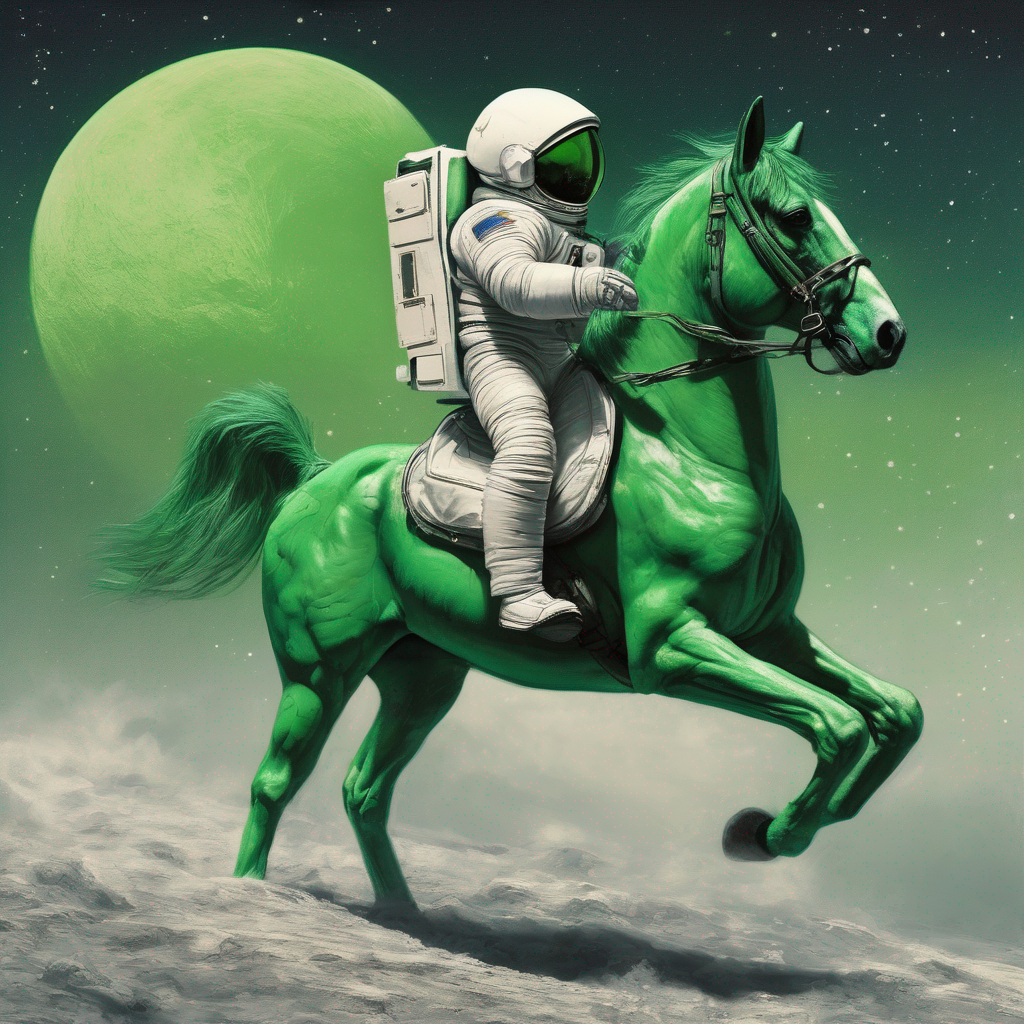

In [7]:
prompt = "An astronaut riding a green horse"
images = pipe(prompt=prompt).images[0]
images

## Save model

In [8]:
p = Path('./models')
p.mkdir(exist_ok=True)

In [12]:
pipe.save_pretrained(p)

In [6]:
!tar zcvf model.tar.gz -C models/ .

./
./model_index.json
./text_encoder/
./text_encoder/model.safetensors
./text_encoder/config.json
./vae/
./vae/diffusion_pytorch_model.safetensors
./vae/config.json
./unet/
./unet/diffusion_pytorch_model.safetensors
./unet/config.json
./tokenizer_2/
./tokenizer_2/tokenizer_config.json
./tokenizer_2/merges.txt
./tokenizer_2/special_tokens_map.json
./tokenizer_2/vocab.json
./text_encoder_2/
./text_encoder_2/model.safetensors
./text_encoder_2/config.json
./tokenizer/
./tokenizer/tokenizer_config.json
./tokenizer/merges.txt
./tokenizer/special_tokens_map.json
./tokenizer/vocab.json
./scheduler/
./scheduler/scheduler_config.json


## Upload model file to s3

In [7]:
import boto3
import sagemaker

In [8]:
boto_session = boto3.Session()
aws_region = boto_session.region_name
sess = sagemaker.Session(boto_session=boto_session)
bucket = sess.default_bucket()

In [9]:
model_s3_path = f"s3://{bucket}/models/stable-diffusion-xl-1.0-base.tar.gz"
model_s3_path

's3://sagemaker-ap-northeast-2-395271362395/models/stable-diffusion-xl-1.0-base.tar.gz'

In [10]:
!aws s3 cp ./model.tar.gz $model_s3_path

upload: ./model.tar.gz to s3://sagemaker-ap-northeast-2-395271362395/models/stable-diffusion-xl-1.0-base.tar.gz
